# 19. Stochastic Integration Intro

**Goal:** Construct the Itô integral, derive Itô's formula, and explore its consequences for geometric Brownian motion and the Itô vs Stratonovich distinction.

Classical Riemann-Stieltjes integration fails for Brownian motion because $B_t$ has **infinite first variation** on every interval. The Itô integral resolves this by:
- Approximating integrands with **simple (step) processes** evaluated at **left endpoints**
- Exploiting the **Itô isometry** $E\!\left[\left(\int_0^T f\,dB\right)^2\right] = E\!\left[\int_0^T f^2\,dt\right]$ to extend to $L^2$

This left-endpoint choice has profound consequences: Itô's formula acquires an extra $\frac{1}{2}f'' \cdot dt$ correction term from the nonzero quadratic variation $[B]_t = t$, which is absent in ordinary calculus and in the Stratonovich convention.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'figure.dpi': 100, 'font.size': 11})

## 1. Why Riemann-Stieltjes Fails & the Itô Integral

For a smooth integrator $g(t)$, the Riemann-Stieltjes integral $\int_0^T f\,dg$ is well-defined because $g$ has **finite first variation**. But Brownian motion has:
$$\text{First Variation: } \sum_{k} |B_{t_{k+1}} - B_{t_k}| \to \infty \quad \text{as mesh} \to 0$$
while its quadratic variation converges: $\sum_k (B_{t_{k+1}} - B_{t_k})^2 \to T$.

The **Itô integral** of an adapted process $f_t$ against $B_t$ is defined as the $L^2$ limit of simple process approximations:
$$\int_0^T f_t\,dB_t = \lim_{n \to \infty} \sum_{k=0}^{n-1} f_{t_k}(B_{t_{k+1}} - B_{t_k})$$
where $f$ is evaluated at the **left endpoint** $t_k$.

**Itô Isometry:** For adapted $f$ with $E\!\left[\int_0^T f_t^2\,dt\right] < \infty$:
$$E\!\left[\left(\int_0^T f_t\,dB_t\right)^{\!2}\right] = E\!\left[\int_0^T f_t^2\,dt\right]$$

We verify this numerically by computing $\int_0^1 B_t\,dB_t$ via left-endpoint sums and checking the isometry.

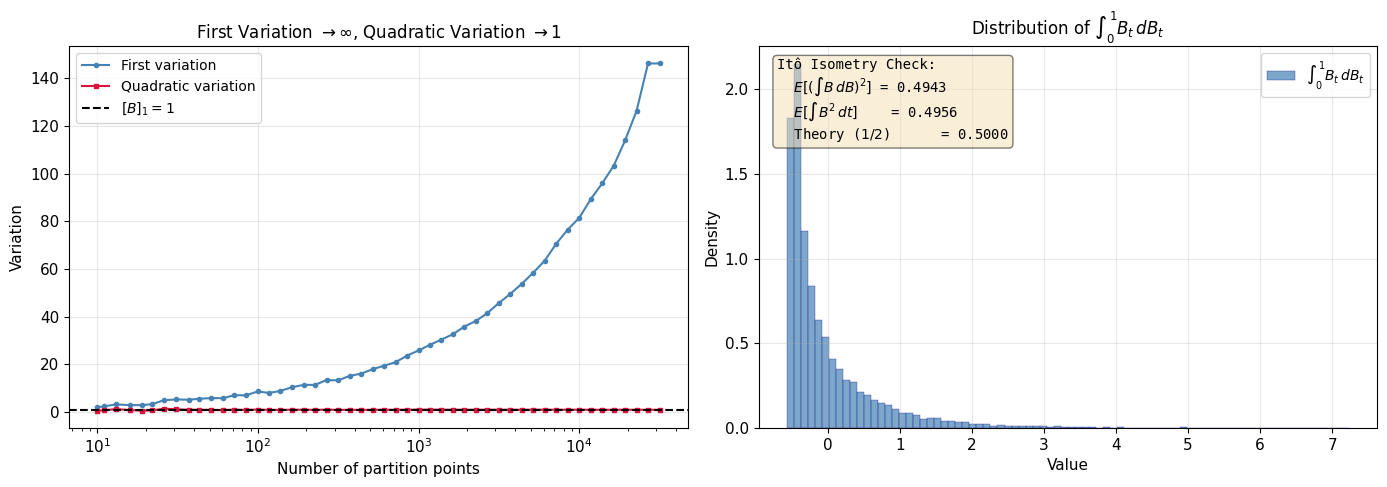

Itô integral mean:          -0.0092  (theory: -0.5 * T = -0.5? No, E=0)
(B_1^2 - 1)/2 mean:         -0.0091
Max |difference| per path:   0.089051
Mean |difference| per path:  0.017790

This confirms: int_0^T B_t dB_t = (B_T^2 - T)/2  (Itô formula)


In [2]:
np.random.seed(42)

# --- Left panel: first variation diverges, quadratic variation converges ---
n_fine = 100000
T = 1.0
dt_fine = T / n_fine
B_fine = np.concatenate([[0], np.cumsum(np.sqrt(dt_fine) * np.random.randn(n_fine))])

n_parts = np.unique(np.logspace(1, 4.5, 50).astype(int))
first_vars = []
quad_vars = []
for n in n_parts:
    step = max(1, n_fine // n)
    idx = np.arange(0, n_fine + 1, step)
    dB = np.diff(B_fine[idx])
    first_vars.append(np.sum(np.abs(dB)))
    quad_vars.append(np.sum(dB**2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.semilogx(n_parts, first_vars, 'o-', color='steelblue', markersize=3, label='First variation')
ax1.semilogx(n_parts, quad_vars, 's-', color='crimson', markersize=3, label='Quadratic variation')
ax1.axhline(y=T, color='black', linestyle='--', linewidth=1.5, label='$[B]_1 = 1$')
ax1.set_xlabel('Number of partition points')
ax1.set_ylabel('Variation')
ax1.set_title('First Variation $\\to \\infty$, Quadratic Variation $\\to 1$', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# --- Right panel: Itô isometry verification ---
# Compute int_0^1 B_t dB_t for many paths
n_paths = 20000
n_steps = 1000
dt = T / n_steps

dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(dW, axis=1)

# Itô integral: sum f(t_k) * dB_k with f = B_{t_k} (left endpoint)
ito_integral = np.sum(B[:, :-1] * dW, axis=1)  # int B_t dB_t

# Itô isometry: E[(int B dB)^2] should equal E[int B^2 dt] = int E[B_t^2] dt = int t dt = 1/2
lhs = np.mean(ito_integral**2)  # E[(int B dB)^2]
rhs = np.mean(np.sum(B[:, :-1]**2 * dt, axis=1))  # E[int B^2 dt]
theory = T**2 / 2  # int_0^1 t dt = 1/2

ax2.hist(ito_integral, bins=80, density=True, color='steelblue', alpha=0.7,
         edgecolor='navy', linewidth=0.3, label='$\\int_0^1 B_t\\,dB_t$')
x_range = np.linspace(-3, 3, 300)
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of $\\int_0^1 B_t\\,dB_t$', fontsize=12)
ax2.grid(True, alpha=0.3)

textstr = (f'Itô Isometry Check:\n'
           f'  $E[(\\int B\\,dB)^2]$ = {lhs:.4f}\n'
           f'  $E[\\int B^2\\,dt]$    = {rhs:.4f}\n'
           f'  Theory ($1/2$)      = {theory:.4f}')
ax2.text(0.03, 0.97, textstr, transform=ax2.transAxes, fontsize=10,
         va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         family='monospace')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Also verify: int B dB = (B_T^2 - T)/2 (Itô formula preview)
ito_formula_val = 0.5 * (B[:, -1]**2 - T)
print(f'Itô integral mean:          {np.mean(ito_integral):.4f}  (theory: -0.5 * T = {-0.5*T}? No, E=0)')
print(f'(B_1^2 - 1)/2 mean:         {np.mean(ito_formula_val):.4f}')
print(f'Max |difference| per path:   {np.max(np.abs(ito_integral - ito_formula_val)):.6f}')
print(f'Mean |difference| per path:  {np.mean(np.abs(ito_integral - ito_formula_val)):.6f}')
print(f'\nThis confirms: int_0^T B_t dB_t = (B_T^2 - T)/2  (Itô formula)')

## 2. Itô's Formula

If $f \in C^2(\mathbb{R})$ and $X_t = B_t$, then **Itô's formula** states:
$$f(B_t) = f(B_0) + \int_0^t f'(B_s)\,dB_s + \frac{1}{2}\int_0^t f''(B_s)\,ds$$

The extra $\frac{1}{2}f''\,ds$ term arises because in the Taylor expansion
$$\Delta f \approx f'\,\Delta B + \tfrac{1}{2}f''\,(\Delta B)^2 + \cdots$$
the second-order term $(\Delta B)^2$ does **not** vanish -- it converges to $dt$ via quadratic variation.

### Example 1: $f(x) = x^2$
$$B_t^2 = 2\int_0^t B_s\,dB_s + t$$
Rearranging: $\int_0^t B_s\,dB_s = \frac{1}{2}(B_t^2 - t)$, which differs from the classical $\frac{1}{2}B_t^2$ by $-t/2$.

### Example 2: Exponential martingale $f(x) = e^{\sigma x - \sigma^2 t/2}$
$$M_t = \exp\!\left(\sigma B_t - \frac{\sigma^2 t}{2}\right)$$
Applying Itô's formula confirms $dM_t = \sigma M_t\,dB_t$ (no $dt$ term), so $M_t$ is a **martingale**.

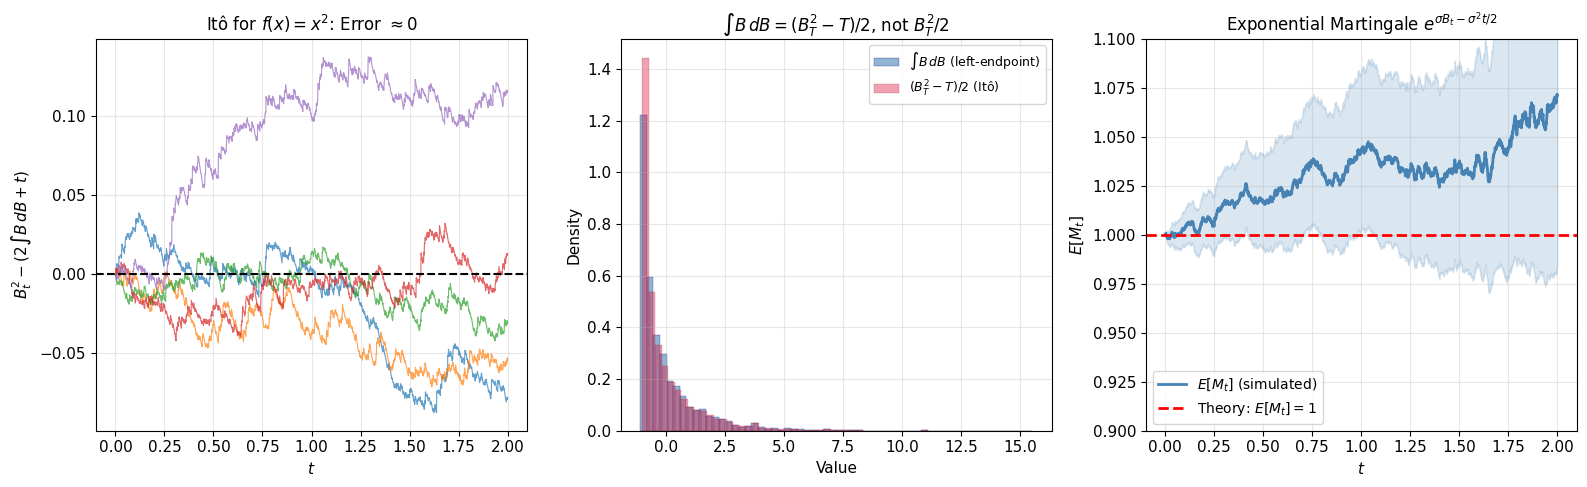

Itô formula B^2 check -- mean absolute error: 0.050268
Exponential martingale E[M_T]: 1.0714  (theory: 1.0)


In [3]:
np.random.seed(123)

n_paths = 5000
n_steps = 2000
T = 2.0
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(dW, axis=1)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Panel 1: Itô formula for B_t^2 ---
ax = axes[0]
# LHS: B_t^2
B_sq = B**2
# RHS: 2*int B dB + t
ito_sum = np.cumsum(B[:, :-1] * dW, axis=1)  # cumulative int B dB
rhs = np.zeros((n_paths, n_steps + 1))
rhs[:, 1:] = 2 * ito_sum + t_grid[1:]

# Show error for a few paths
for i in range(5):
    error = B_sq[i] - rhs[i]
    ax.plot(t_grid, error, linewidth=0.8, alpha=0.7)

ax.axhline(y=0, color='black', linewidth=1.5, linestyle='--')
ax.set_xlabel('$t$')
ax.set_ylabel('$B_t^2 - (2\\int B\\,dB + t)$')
ax.set_title('Itô for $f(x)=x^2$: Error $\\approx 0$', fontsize=12)
ax.grid(True, alpha=0.3)

# --- Panel 2: Classical vs Itô comparison ---
ax = axes[1]
# int B dB via left-endpoint sum
ito_int_final = np.sum(B[:, :-1] * dW, axis=1)
ito_result = 0.5 * (B[:, -1]**2 - T)  # Itô: (B_T^2 - T)/2
classical_result = 0.5 * B[:, -1]**2   # Classical: B_T^2/2

ax.hist(ito_int_final, bins=60, density=True, alpha=0.6, color='steelblue',
        label='$\\int B\\,dB$ (left-endpoint)', edgecolor='navy', linewidth=0.3)
ax.hist(ito_result, bins=60, density=True, alpha=0.4, color='crimson',
        label='$(B_T^2 - T)/2$ (Itô)', edgecolor='darkred', linewidth=0.3)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('$\\int B\\,dB = (B_T^2 - T)/2$, not $B_T^2/2$', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 3: Exponential martingale ---
ax = axes[2]
sigma = 1.0
M = np.exp(sigma * B - 0.5 * sigma**2 * t_grid[np.newaxis, :])  # (n_paths, n_steps+1)

# E[M_t] should be 1 for all t (martingale)
mean_M = np.mean(M, axis=0)
std_M = np.std(M, axis=0) / np.sqrt(n_paths)

ax.plot(t_grid, mean_M, 'steelblue', linewidth=2, label='$E[M_t]$ (simulated)')
ax.fill_between(t_grid, mean_M - 2*std_M, mean_M + 2*std_M,
                alpha=0.2, color='steelblue')
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Theory: $E[M_t]=1$')
ax.set_xlabel('$t$')
ax.set_ylabel('$E[M_t]$')
ax.set_title('Exponential Martingale $e^{\\sigma B_t - \\sigma^2 t/2}$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.9, 1.1)

plt.tight_layout()
plt.show()

print(f'Itô formula B^2 check -- mean absolute error: {np.mean(np.abs(B_sq[:, -1] - rhs[:, -1])):.6f}')
print(f'Exponential martingale E[M_T]: {np.mean(M[:, -1]):.4f}  (theory: 1.0)')

## 3. Geometric Brownian Motion

The **GBM** SDE models stock prices:
$$dS_t = \mu S_t\,dt + \sigma S_t\,dB_t, \quad S_0 > 0$$

To solve, let $Y_t = \ln S_t$ and apply Itô's formula with $f(x) = \ln x$:
$$dY_t = f'(S_t)\,dS_t + \tfrac{1}{2}f''(S_t)\,(dS_t)^2 = \frac{dS_t}{S_t} - \frac{1}{2}\frac{(dS_t)^2}{S_t^2}$$
$$= \left(\mu - \tfrac{\sigma^2}{2}\right)dt + \sigma\,dB_t$$

Integrating:
$$S_t = S_0 \exp\!\left[\left(\mu - \tfrac{\sigma^2}{2}\right)t + \sigma B_t\right]$$

Key consequences:
- $\ln S_t \sim \mathcal{N}\!\left(\ln S_0 + (\mu - \sigma^2/2)t,\; \sigma^2 t\right)$ -- **lognormal** distribution
- The drift correction $-\sigma^2/2$ (the "Itô correction") is why the median growth rate is less than $\mu$

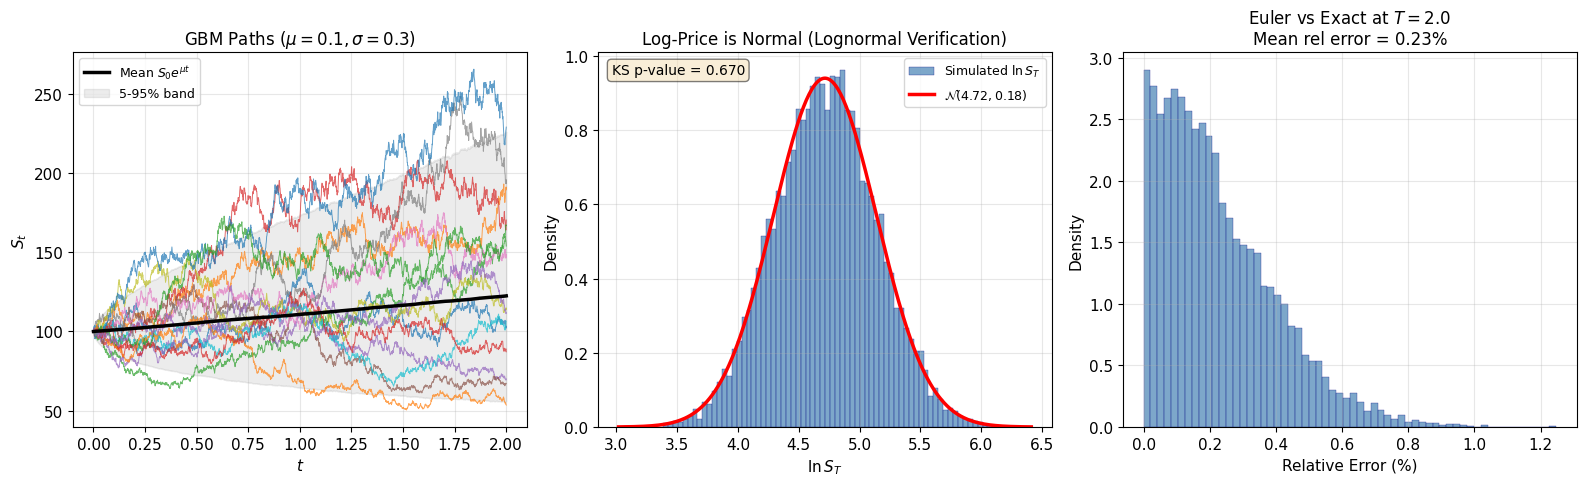

Theoretical E[S_T] = S0 * exp(mu*T) = 122.14
Simulated   E[S_T] = 122.49
Theoretical median  = S0 * exp((mu - sigma^2/2)*T) = 111.63
Simulated   median  = 111.99

Note: mean > median due to lognormal skewness (Itô correction effect)


In [4]:
np.random.seed(2024)

# GBM parameters
S0 = 100.0
mu = 0.10       # drift
sigma = 0.30    # volatility
T = 2.0
n_steps = 2000
n_paths = 10000
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(dW, axis=1)

# Exact solution
S_exact = S0 * np.exp((mu - 0.5 * sigma**2) * t_grid[np.newaxis, :] + sigma * B)

# Euler-Maruyama discretization for comparison
S_euler = np.zeros((n_paths, n_steps + 1))
S_euler[:, 0] = S0
for k in range(n_steps):
    S_euler[:, k+1] = S_euler[:, k] * (1 + mu * dt + sigma * dW[:, k])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Panel 1: sample paths ---
ax = axes[0]
for i in range(15):
    ax.plot(t_grid, S_exact[i], linewidth=0.7, alpha=0.7)
# Mean and quantiles
mean_S = np.mean(S_exact, axis=0)
q05 = np.percentile(S_exact, 5, axis=0)
q95 = np.percentile(S_exact, 95, axis=0)
ax.plot(t_grid, mean_S, 'k-', linewidth=2.5, label=f'Mean $S_0 e^{{\\mu t}}$')
ax.fill_between(t_grid, q05, q95, alpha=0.15, color='grey', label='5-95% band')
ax.set_xlabel('$t$')
ax.set_ylabel('$S_t$')
ax.set_title(f'GBM Paths ($\\mu={mu}, \\sigma={sigma}$)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 2: terminal distribution vs lognormal ---
ax = axes[1]
S_T = S_exact[:, -1]
log_S_T = np.log(S_T)

# Theoretical: ln(S_T) ~ N(ln(S0) + (mu - sigma^2/2)*T, sigma^2*T)
theory_mean = np.log(S0) + (mu - 0.5 * sigma**2) * T
theory_std = sigma * np.sqrt(T)

ax.hist(log_S_T, bins=80, density=True, color='steelblue', alpha=0.7,
        edgecolor='navy', linewidth=0.3, label='Simulated $\\ln S_T$')
x_range = np.linspace(theory_mean - 4*theory_std, theory_mean + 4*theory_std, 300)
ax.plot(x_range, stats.norm.pdf(x_range, theory_mean, theory_std),
        'r-', linewidth=2.5, label=f'$\\mathcal{{N}}({theory_mean:.2f}, {theory_std**2:.2f})$')
ax.set_xlabel('$\\ln S_T$')
ax.set_ylabel('Density')
ax.set_title('Log-Price is Normal (Lognormal Verification)', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# KS test
ks_stat, ks_p = stats.kstest(log_S_T, 'norm', args=(theory_mean, theory_std))
ax.text(0.03, 0.97, f'KS p-value = {ks_p:.3f}', transform=ax.transAxes,
        fontsize=10, va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# --- Panel 3: Exact vs Euler-Maruyama ---
ax = axes[2]
# Compare terminal values
rel_error = np.abs(S_euler[:, -1] - S_exact[:, -1]) / S_exact[:, -1]
ax.hist(rel_error * 100, bins=60, density=True, color='steelblue', alpha=0.7,
        edgecolor='navy', linewidth=0.3)
ax.set_xlabel('Relative Error (%)')
ax.set_ylabel('Density')
ax.set_title(f'Euler vs Exact at $T={T}$\nMean rel error = {np.mean(rel_error)*100:.2f}%', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Theoretical E[S_T] = S0 * exp(mu*T) = {S0 * np.exp(mu * T):.2f}')
print(f'Simulated   E[S_T] = {np.mean(S_T):.2f}')
print(f'Theoretical median  = S0 * exp((mu - sigma^2/2)*T) = {S0 * np.exp((mu - 0.5*sigma**2)*T):.2f}')
print(f'Simulated   median  = {np.median(S_T):.2f}')
print(f'\nNote: mean > median due to lognormal skewness (Itô correction effect)')

## 4. Itô vs Stratonovich Integration

The **Stratonovich integral** uses **midpoint** evaluation instead of left-endpoint:
$$\int_0^T f_t \circ dB_t = \lim_{n \to \infty} \sum_{k=0}^{n-1} f\!\left(\frac{t_k + t_{k+1}}{2}\right)(B_{t_{k+1}} - B_{t_k})$$

The relationship between the two is:
$$\int_0^T f(B_t) \circ dB_t = \int_0^T f(B_t)\,dB_t + \frac{1}{2}\int_0^T f'(B_t)\,dt$$

**Key example:** $\int_0^T B_t\,dB_t$ vs $\int_0^T B_t \circ dB_t$:
- **Itô:** $\int_0^T B_t\,dB_t = \frac{1}{2}(B_T^2 - T)$ (left-endpoint $\Rightarrow$ correction term)
- **Stratonovich:** $\int_0^T B_t \circ dB_t = \frac{1}{2}B_T^2$ (midpoint $\Rightarrow$ classical chain rule)

The difference is exactly $\frac{1}{2}\int_0^T 1\,dt = T/2$, since $f(x) = x \Rightarrow f'(x) = 1$.

Stratonovich preserves the classical chain rule but loses the martingale property. Itô preserves the martingale property but requires the correction term. The choice depends on the modeling context.

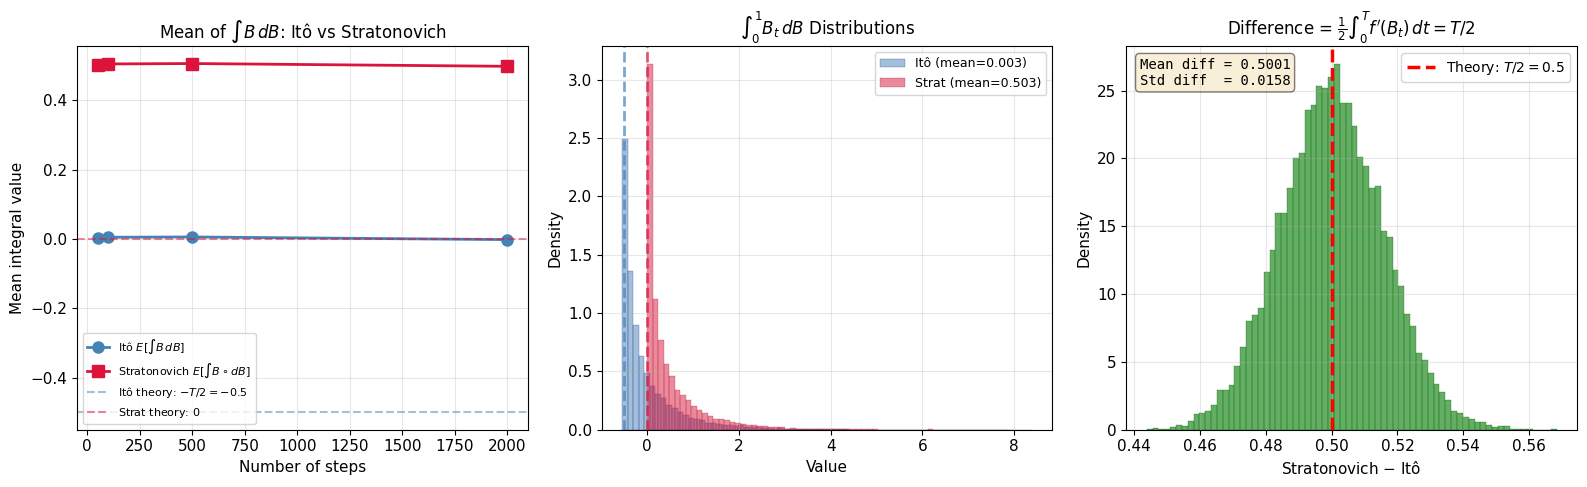

Itô mean:          0.0032   (theory: -0.5000)
Stratonovich mean: 0.5033   (theory: 0.0000)
Difference mean:   0.5001   (theory: 0.5000)


In [5]:
np.random.seed(999)

n_paths = 20000
T = 1.0

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# --- Panel 1: Itô vs Stratonovich for int B dB at multiple resolutions ---
ax = axes[0]
n_steps_list = [50, 100, 500, 2000]
ito_means = []
strat_means = []

for n_steps in n_steps_list:
    dt = T / n_steps
    dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
    B = np.zeros((n_paths, n_steps + 1))
    B[:, 1:] = np.cumsum(dW, axis=1)
    
    # Left-endpoint (Itô)
    ito_val = np.sum(B[:, :-1] * dW, axis=1)
    
    # Midpoint (Stratonovich): use (B_{k} + B_{k+1})/2
    B_mid = 0.5 * (B[:, :-1] + B[:, 1:])
    strat_val = np.sum(B_mid * dW, axis=1)
    
    ito_means.append(np.mean(ito_val))
    strat_means.append(np.mean(strat_val))

ax.plot(n_steps_list, ito_means, 'o-', color='steelblue', linewidth=2, markersize=8,
        label='Itô $E[\\int B\\,dB]$')
ax.plot(n_steps_list, strat_means, 's-', color='crimson', linewidth=2, markersize=8,
        label='Stratonovich $E[\\int B \\circ dB]$')
ax.axhline(y=-T/2, color='steelblue', linestyle='--', alpha=0.5, label=f'Itô theory: $-T/2 = {-T/2}$')
ax.axhline(y=0, color='crimson', linestyle='--', alpha=0.5, label='Strat theory: $0$')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Mean integral value')
ax.set_title('Mean of $\\int B\\,dB$: Itô vs Stratonovich', fontsize=12)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# --- Panel 2: Distributions side by side ---
ax = axes[1]
n_steps = 2000
dt = T / n_steps
dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
B = np.zeros((n_paths, n_steps + 1))
B[:, 1:] = np.cumsum(dW, axis=1)

ito_val = np.sum(B[:, :-1] * dW, axis=1)
B_mid = 0.5 * (B[:, :-1] + B[:, 1:])
strat_val = np.sum(B_mid * dW, axis=1)

ax.hist(ito_val, bins=70, density=True, alpha=0.5, color='steelblue',
        edgecolor='navy', linewidth=0.3, label=f'Itô (mean={np.mean(ito_val):.3f})')
ax.hist(strat_val, bins=70, density=True, alpha=0.5, color='crimson',
        edgecolor='darkred', linewidth=0.3, label=f'Strat (mean={np.mean(strat_val):.3f})')
ax.axvline(x=-T/2, color='steelblue', linestyle='--', linewidth=2, alpha=0.7)
ax.axvline(x=0, color='crimson', linestyle='--', linewidth=2, alpha=0.7)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title(f'$\\int_0^{{{T:.0f}}} B_t\\,dB$ Distributions', fontsize=12)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# --- Panel 3: Difference = T/2 ---
ax = axes[2]
diff = strat_val - ito_val
ax.hist(diff, bins=70, density=True, color='forestgreen', alpha=0.7,
        edgecolor='darkgreen', linewidth=0.3)
ax.axvline(x=T/2, color='red', linestyle='--', linewidth=2.5, label=f'Theory: $T/2 = {T/2}$')
ax.set_xlabel('Stratonovich $-$ Itô')
ax.set_ylabel('Density')
ax.set_title(f'Difference = $\\frac{{1}}{{2}}\\int_0^T f\'(B_t)\\,dt = T/2$', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Statistics
ax.text(0.03, 0.97, f'Mean diff = {np.mean(diff):.4f}\nStd diff  = {np.std(diff):.4f}',
        transform=ax.transAxes, fontsize=10, va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), family='monospace')

plt.tight_layout()
plt.show()

print(f'Itô mean:          {np.mean(ito_val):.4f}   (theory: {-T/2:.4f})')
print(f'Stratonovich mean: {np.mean(strat_val):.4f}   (theory: 0.0000)')
print(f'Difference mean:   {np.mean(diff):.4f}   (theory: {T/2:.4f})')

## 5. Convergence of Simple Process Approximations

The Itô integral is built as the $L^2$ limit of integrals of **simple processes**:
$$I_n = \sum_{k=0}^{n-1} f(t_k)\,(B_{t_{k+1}} - B_{t_k}) \xrightarrow{L^2} \int_0^T f(B_t)\,dB_t$$

The rate of convergence in $L^2$ is $O(1/\sqrt{n})$ for Lipschitz integrands. We verify this by computing the approximation error for $\int_0^1 B_t\,dB_t = (B_1^2 - 1)/2$ at increasing partition refinements.

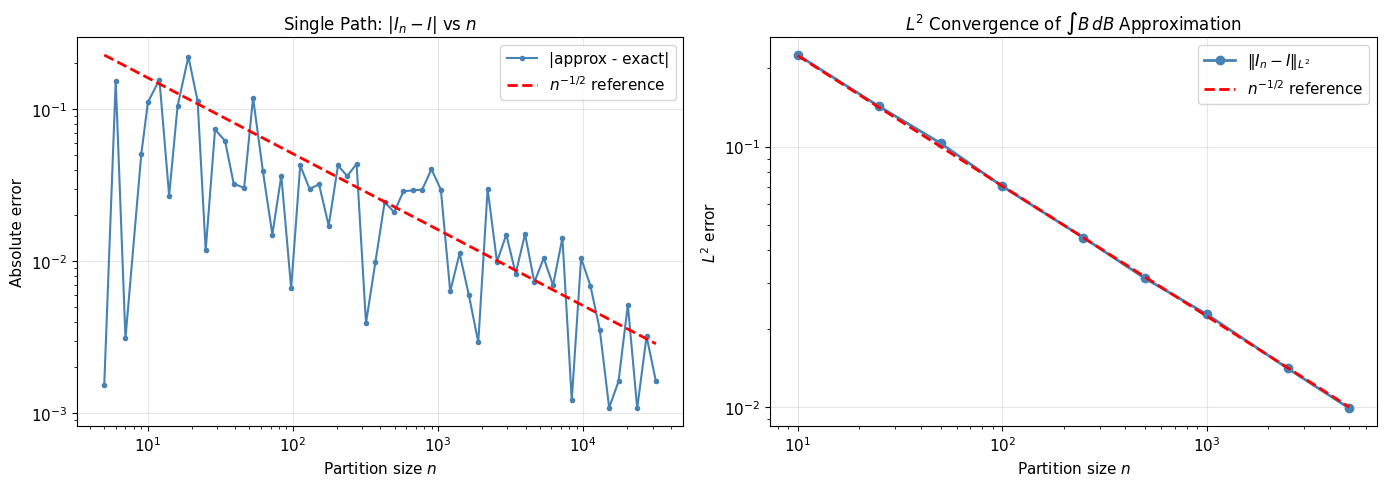

Estimated L^2 convergence rate: n^-0.503  (theory: n^{-0.5})


In [6]:
np.random.seed(314)

# Generate a very fine Brownian motion
n_fine = 200000
T = 1.0
dt_fine = T / n_fine
dW_fine = np.sqrt(dt_fine) * np.random.randn(n_fine)
B_fine = np.concatenate([[0], np.cumsum(dW_fine)])

# "Exact" value via Itô formula
exact_val = 0.5 * (B_fine[-1]**2 - T)

# Compute left-endpoint Riemann sum at various partition sizes
n_parts = np.unique(np.logspace(0.7, 4.5, 60).astype(int))
errors = []

for n in n_parts:
    step = max(1, n_fine // n)
    idx = np.arange(0, n_fine + 1, step)
    if idx[-1] != n_fine:
        idx = np.append(idx, n_fine)
    B_part = B_fine[idx]
    # Left-endpoint sum: sum B_{t_k} * (B_{t_{k+1}} - B_{t_k})
    approx = np.sum(B_part[:-1] * np.diff(B_part))
    errors.append(np.abs(approx - exact_val))

# Now repeat for many paths to get L^2 error
n_mc = 2000
n_list = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000]
l2_errors = []

for n in n_list:
    dt = T / n
    dW_mc = np.sqrt(dt) * np.random.randn(n_mc, n)
    B_mc = np.zeros((n_mc, n + 1))
    B_mc[:, 1:] = np.cumsum(dW_mc, axis=1)
    approx_mc = np.sum(B_mc[:, :-1] * dW_mc, axis=1)
    exact_mc = 0.5 * (B_mc[:, -1]**2 - T)
    l2_errors.append(np.sqrt(np.mean((approx_mc - exact_mc)**2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: single path convergence
ax1.loglog(n_parts, errors, 'o-', color='steelblue', markersize=3, label='|approx - exact|')
# Reference line
c_ref = errors[len(errors)//2] * n_parts[len(n_parts)//2]**0.5
ax1.loglog(n_parts, c_ref * n_parts**(-0.5), 'r--', linewidth=2, label='$n^{-1/2}$ reference')
ax1.set_xlabel('Partition size $n$')
ax1.set_ylabel('Absolute error')
ax1.set_title('Single Path: $|I_n - I|$ vs $n$', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: L^2 error over many paths
ax2.loglog(n_list, l2_errors, 'o-', color='steelblue', markersize=6, linewidth=2,
           label='$\\|I_n - I\\|_{L^2}$')
c_ref2 = l2_errors[len(l2_errors)//2] * n_list[len(n_list)//2]**0.5
ax2.loglog(n_list, [c_ref2 * n**(-0.5) for n in n_list], 'r--', linewidth=2,
           label='$n^{-1/2}$ reference')
ax2.set_xlabel('Partition size $n$')
ax2.set_ylabel('$L^2$ error')
ax2.set_title('$L^2$ Convergence of $\\int B\\,dB$ Approximation', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estimate convergence rate
log_n = np.log(n_list)
log_err = np.log(l2_errors)
slope, intercept = np.polyfit(log_n, log_err, 1)
print(f'Estimated L^2 convergence rate: n^{slope:.3f}  (theory: n^{{-0.5}})')

## 6. GBM: The Itô Correction in Action

The Itô correction has tangible financial consequences. For GBM with drift $\mu$ and volatility $\sigma$:

| Quantity | Formula |
|:---|:---|
| Expected value | $E[S_t] = S_0 e^{\mu t}$ |
| Median | $\text{med}(S_t) = S_0 e^{(\mu - \sigma^2/2) t}$ |
| Log-return mean | $(\mu - \sigma^2/2) t$ |

The gap between mean and median grows with volatility, a direct manifestation of the $-\sigma^2/2$ Itô correction. With high volatility, most paths underperform the mean because a few extreme paths pull the average up.

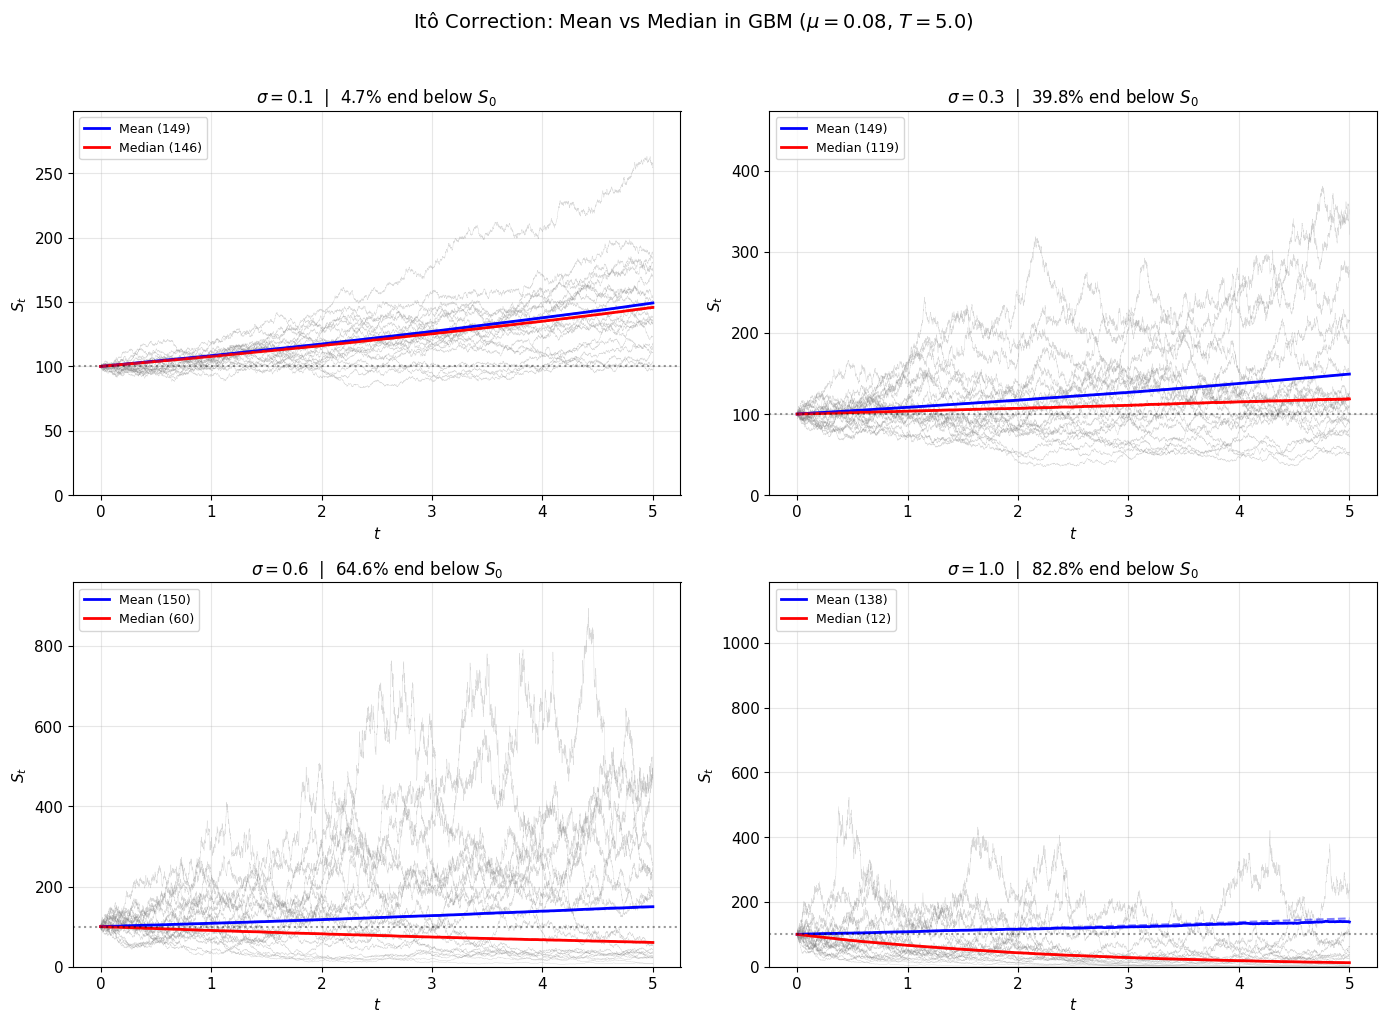

Itô correction effect summary:
   sigma     E[S_T]   med(S_T)   % below S0   correction
--------------------------------------------------------
    0.10     149.18     145.50         4.7%        0.025
    0.30     149.18     119.12        39.7%        0.225
    0.60     149.18      60.65        64.5%        0.900
    1.00     149.18      12.25        82.6%        2.500


/var/folders/22/xxwj0_711b34fsf64tkzj_ph0000gn/T/ipykernel_92775/3110775816.py:61: RuntimeWarning: invalid value encountered in log
  frac = stats.norm.cdf(-np.log(S0 / S0 + (mu - 0.5*sigma**2)*T) / (sigma * np.sqrt(T)) + (mu - 0.5*sigma**2)*np.sqrt(T)/sigma)


In [7]:
np.random.seed(77)

S0 = 100.0
mu = 0.08
T = 5.0
n_steps = 5000
n_paths = 50000
dt = T / n_steps
t_grid = np.linspace(0, T, n_steps + 1)

sigma_values = [0.10, 0.30, 0.60, 1.00]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, sigma in enumerate(sigma_values):
    ax = axes[idx // 2, idx % 2]
    
    dW = np.sqrt(dt) * np.random.randn(n_paths, n_steps)
    B = np.zeros((n_paths, n_steps + 1))
    B[:, 1:] = np.cumsum(dW, axis=1)
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t_grid[np.newaxis, :] + sigma * B)
    
    # Mean and median paths
    mean_path = np.mean(S, axis=0)
    median_path = np.median(S, axis=0)
    theory_mean = S0 * np.exp(mu * t_grid)
    theory_median = S0 * np.exp((mu - 0.5 * sigma**2) * t_grid)
    
    # Fraction of paths below S0
    frac_below = np.mean(S[:, -1] < S0)
    
    # Plot a few paths
    for i in range(20):
        ax.plot(t_grid, S[i], linewidth=0.3, alpha=0.3, color='grey')
    
    ax.plot(t_grid, mean_path, 'b-', linewidth=2, label=f'Mean ({mean_path[-1]:.0f})')
    ax.plot(t_grid, median_path, 'r-', linewidth=2, label=f'Median ({median_path[-1]:.0f})')
    ax.plot(t_grid, theory_mean, 'b--', linewidth=1.5, alpha=0.5)
    ax.plot(t_grid, theory_median, 'r--', linewidth=1.5, alpha=0.5)
    ax.axhline(y=S0, color='black', linestyle=':', alpha=0.4)
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$S_t$')
    ax.set_title(f'$\\sigma = {sigma}$  |  {frac_below*100:.1f}% end below $S_0$', fontsize=12)
    ax.legend(fontsize=9, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(2 * S0 * np.exp(mu * T), np.percentile(S[:, -1], 98)))

plt.suptitle(f'Itô Correction: Mean vs Median in GBM ($\\mu = {mu}$, $T = {T}$)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print('Itô correction effect summary:')
print(f'{"sigma":>8} {"E[S_T]":>10} {"med(S_T)":>10} {"% below S0":>12} {"correction":>12}')
print('-' * 56)
for sigma in sigma_values:
    em = S0 * np.exp(mu * T)
    med = S0 * np.exp((mu - 0.5 * sigma**2) * T)
    corr = 0.5 * sigma**2 * T
    frac = stats.norm.cdf(-np.log(S0 / S0 + (mu - 0.5*sigma**2)*T) / (sigma * np.sqrt(T)) + (mu - 0.5*sigma**2)*np.sqrt(T)/sigma)
    frac_exact = stats.norm.cdf(-(mu - 0.5*sigma**2)*np.sqrt(T)/sigma)
    print(f'{sigma:>8.2f} {em:>10.2f} {med:>10.2f} {frac_exact*100:>11.1f}% {corr:>12.3f}')

## Key Takeaways

1. **Riemann-Stieltjes fails for BM:** Brownian motion has infinite first variation, so classical path-by-path integration is undefined. The Itô integral bypasses this via $L^2$ limits of simple process sums.

2. **Itô isometry:** $E[(\int f\,dB)^2] = E[\int f^2\,dt]$ -- this is the engine that extends the integral from simple processes to all adapted $L^2$ integrands, and it confirms the Itô integral is an isometry from $L^2(\Omega \times [0,T])$ to $L^2(\Omega)$.

3. **Itô's formula** acquires the correction $+\frac{1}{2}f''\,dt$ from quadratic variation. This single fact is responsible for:
   - $\int B\,dB = (B^2 - t)/2$ instead of $B^2/2$
   - The exponential martingale $e^{\sigma B - \sigma^2 t/2}$
   - The drift correction $\mu - \sigma^2/2$ in GBM log-returns

4. **Geometric Brownian Motion:** $S_t = S_0 \exp((\mu - \sigma^2/2)t + \sigma B_t)$ is lognormal. The Itô correction $-\sigma^2/2$ means the **median** growth rate is less than $\mu$, and more paths lose money as volatility increases.

5. **Itô vs Stratonovich:** Left-endpoint (Itô) produces martingales and the correction term; midpoint (Stratonovich) recovers the classical chain rule. They differ by $\frac{1}{2}\int f'\,dt$. Itô is standard in finance; Stratonovich appears in physics where noise has a small correlation time.

6. **The $L^2$ convergence rate** of partition approximations to the Itô integral is $O(n^{-1/2})$, reflecting the fundamental roughness of Brownian paths.